In [5]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [6]:
# create dataframe from csv file
df = pd.read_csv('../data/timeseries-KTG-wonosobo.csv')
df.head()

,tanggal,harga
0,2021-01-01,9000.0
1,2021-01-02,9000.0
2,2021-01-03,9000.0
3,2021-01-04,9000.0
4,2021-01-05,9000.0


In [7]:
data = df[['tanggal','harga']]
data.index = df['tanggal']
data.head()

,tanggal,harga
tanggal,,
2021-01-01,2021-01-01,9000.0
2021-01-02,2021-01-02,9000.0
2021-01-03,2021-01-03,9000.0
2021-01-04,2021-01-04,9000.0
2021-01-05,2021-01-05,9000.0


<Axes: xlabel='tanggal'>

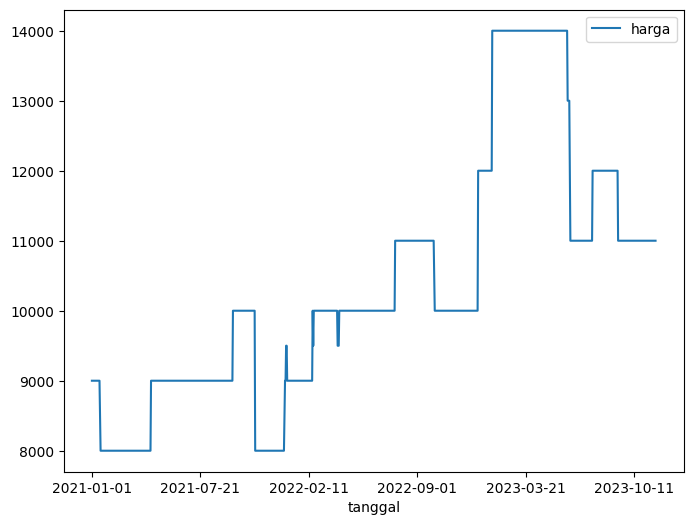

In [8]:
data.plot()

In [9]:
# dataset = data.values
# dataset
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data['harga'].values.reshape(-1, 1))

In [10]:
# ## train test split for simple time series moving window average
# train_split = 800
# tf.random.set_seed(13)

# ### standardize data
# uni_data_mean = dataset[:train_split].mean()
# uni_data_std = dataset[:train_split].std()
# uni_data  = (dataset - uni_data_mean)/ uni_data_std

# print(type(uni_data))
# print(uni_data)

In [11]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## last 20 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

NameError: name 'uni_data' is not defined

In [ ]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(780, 20, 1) (780,)
(235, 20, 1) (235,)


In [ ]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])


Single window of history data [[-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.52616945]
 [-0.84627254]
 [-1.16637563]
 [-1.16637563]
 [-1.16637563]
 [-1.16637563]]
Target Temperature to predict  -1.1663756334406918


In [12]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

NameError: name 'x_train_uni' is not defined

<module 'matplotlib.pyplot' from '/Volumes/DataQ/Tugas Akhir/lstm-predict-potato-price/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

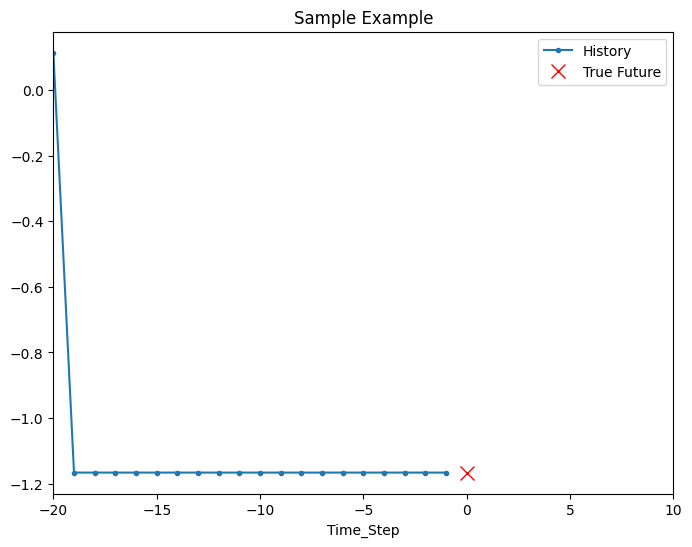

In [ ]:
i = 300
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [ ]:
### Moving window average

def MWA(history):
  return np.mean(history)


<module 'matplotlib.pyplot' from '/Volumes/DataQ/Tugas Akhir/lstm-predict-potato-price/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

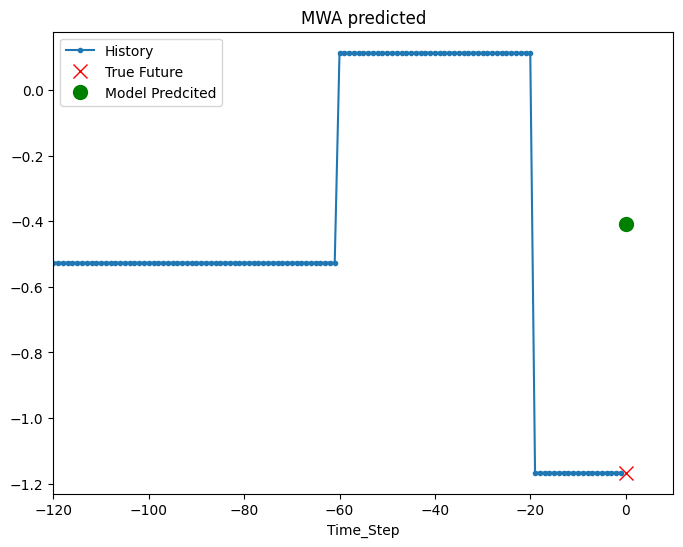

In [ ]:
i = 200
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

In [ ]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
## Define LSTM model 

# lstm_model = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(60, return_sequences=True, input_shape = x_train_uni.shape[-2:]),
#     tf.keras.layers.LSTM(60),
#     tf.keras.layers.Dense(30, activation="relu"),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(10, activation="relu"),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1)
#   ])
lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(20 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])
lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS = 50

history = lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)


Epoch 1/50
200/200 [==============================] - 4s 12ms/step - loss: 0.2317 - val_loss: 0.1190
Epoch 2/50
200/200 [==============================] - 2s 12ms/step - loss: 0.0498 - val_loss: 0.0766
Epoch 3/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0420 - val_loss: 0.0607
Epoch 4/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0367 - val_loss: 0.0528
Epoch 5/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0324 - val_loss: 0.0424
Epoch 6/50
200/200 [==============================] - 2s 10ms/step - loss: 0.0308 - val_loss: 0.0399
Epoch 7/50
200/200 [==============================] - 3s 14ms/step - loss: 0.0285 - val_loss: 0.0389
Epoch 8/50
200/200 [==============================] - 3s 13ms/step - loss: 0.0269 - val_loss: 0.0393
Epoch 9/50
200/200 [==============================] - 2s 11ms/step - loss: 0.0251 - val_loss: 0.0312
Epoch 10/50
200/200 [==============================] - 2s 9ms/step - loss: 0.0241 - val_los

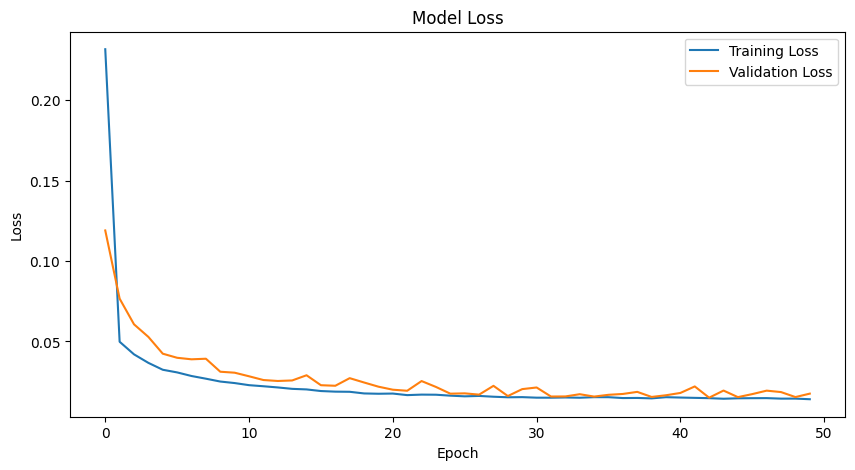

In [ ]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

8/8 [==============================] - 1s 4ms/step


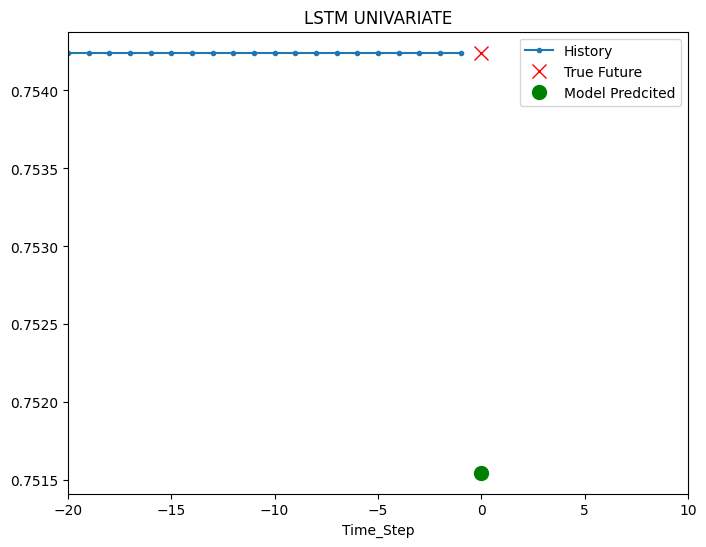

8/8 [==============================] - 0s 4ms/step


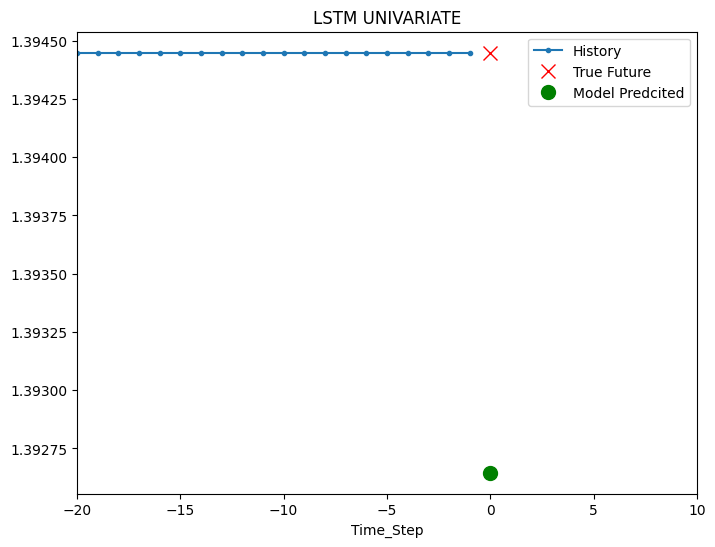

8/8 [==============================] - 0s 4ms/step


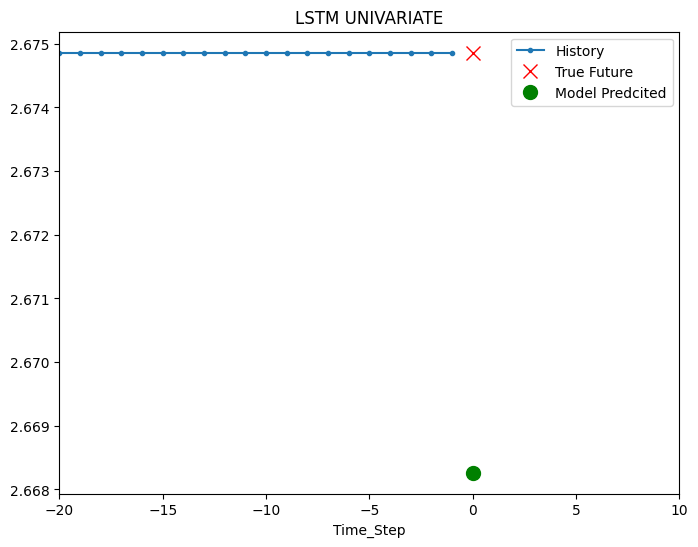

8/8 [==============================] - 0s 7ms/step


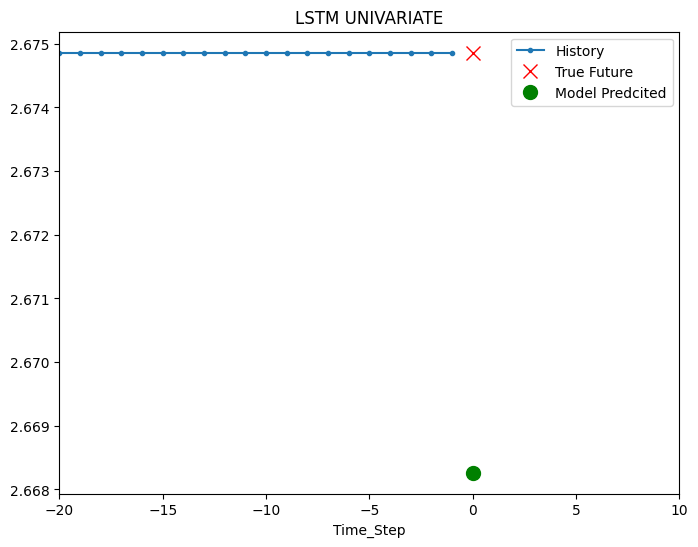

8/8 [==============================] - 0s 4ms/step


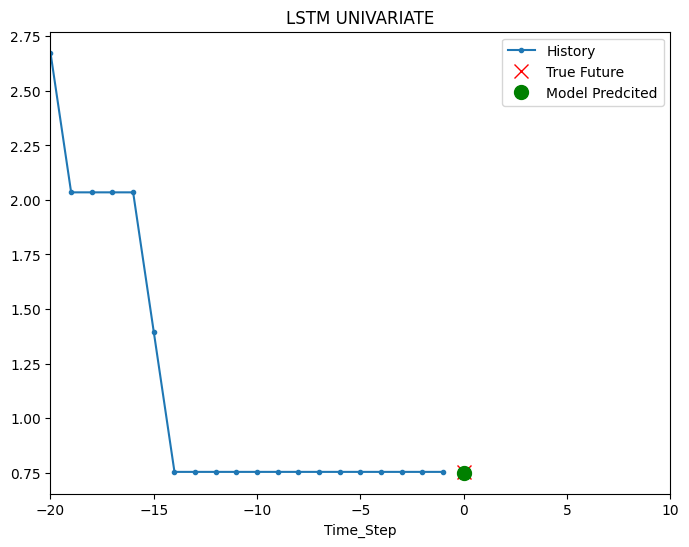

In [ ]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

In [ ]:
trainPredict = lstm_model.predict(x_train_uni)
testPredict = lstm_model.predict(x_val_uni)

# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train_uni])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_val_uni])

# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

8/8 [==============================] - 0s 3ms/step
Train Score: 593.76 RMSE
Test Score: 557.00 RMSE


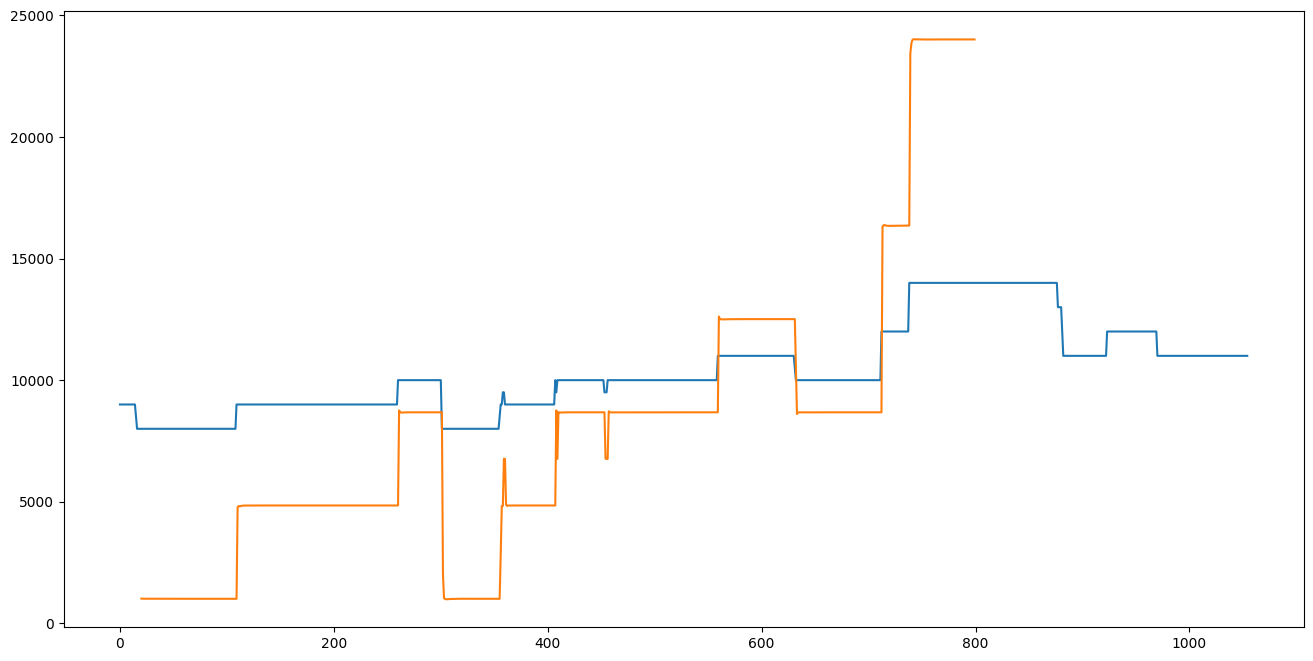

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[uni_data_history:len(trainPredict)+uni_data_history, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(uni_data_history*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/6, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/6, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  
for x, y in train_uni.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

TypeError: Scalar tensor has no `len()`

<Figure size 1200x600 with 0 Axes>